# Install depedencies and importing

In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
import os
import random
import numpy as np
import json
import tqdm
import networkx as nx
from collections import defaultdict
from time import time
from torch_geometric.datasets import Planetoid
from utils import *
from loss_functions import *

In [1]:
# import GCNs model
from GCN import *
# import other GNNs
from otherGNNs import *

In [2]:
%load_ext autoreload
%autoreload 2

In [30]:
# load cora
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)
dataset = Planetoid(root=data_dir, name='Cora')
data = dataset[0]

Processing...
Done!


In [65]:
sk_ising = []
for u, v in data.edge_index.numpy().T:
    sk_ising.append((u, v, np.random.randint(-5, 5)))

In [66]:
import fasthare as m
print("Using list of triples i, j, h_ij")
# sk_ising = [(0, 1, -3)] # SK Hamiltonian: min - (-3 * x_0  * x_1 )
print(m.fasthare_reduction(sk_ising, alpha=0.2) )
rh, map, sign, time1 = m.fasthare_reduction(sk_ising,alpha=0.2)

# Or using the exp3.net in the "tests" folder
# print("Reading triples i, j, h_ij from file")
# rh, map, sign, time1 = m.fasthare_reduction(file ="exp3.net",alpha=0.2)
print(rh) 
print(map)
print(sign)
print(time1)


Using list of triples i, j, h_ij
([(0, 1378, 2.0), (0, 1298, 4.0), (0, 1298, 2.0), (0, 660, 4.0), (0, 638, -1.0), (0, 1046, 4.0), (0, 1378, -4.0), (1, 95, -3.0), (1, 734, -2.0), (1, 1044, 8.0), (1, 1372, 3.0), (1, 95, 3.0), (1, 734, 3.0), (1, 1081, -2.0), (2, 287, -1.0), (2, 287, 1.0), (3, 660, 1.0), (3, 821, 2.0), (3, 426, 2.0), (3, 1172, 1.0), (3, 699, -7.0), (3, 614, 3.0), (3, 426, 3.0), (3, 498, -1.0), (4, 82, -2.0), (4, 1256, -1.0), (4, 82, 2.0), (4, 384, 2.0), (4, 1361, 2.0), (4, 384, -5.0), (4, 1256, -1.0), (4, 856, -2.0), (5, 411, -4.0), (5, 417, 2.0), (5, 422, -5.0), (5, 411, -1.0), (5, 417, 1.0), (5, 422, -2.0), (6, 660, 5.0), (6, 1187, -2.0), (6, 1187, 3.0), (6, 1172, -5.0), (7, 667, 2.0), (7, 890, -5.0), (7, 890, -4.0), (7, 667, -2.0), (8, 818, -4.0), (8, 281, -4.0), (8, 818, -5.0), (8, 281, 2.0), (8, 1154, 6.0), (9, 1144, 6.0), (9, 102, 1.0), (9, 1074, -3.0), (9, 102, 1.0), (9, 1146, -2.0), (10, 775, 1.0), (10, 89, -2.0), (10, 342, -4.0), (10, 775, -4.0), (10, 89, -2.0), (

In [70]:
adj_label = []
for i in range(len(map)):
    for j in range(len(map)):
        if map[i]!=map[j] or i==j:
            adj_label.append(0)
        else:
            adj_label.append(1)
adj_label = torch.tensor(adj_label, dtype=torch.float64)


In [13]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float64
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')


Will use device: cuda, torch dtype: torch.float64


In [7]:
"""
- load graph
    (u, v, w)
- labels
    fasthare reduction
- train/test mask
"""

# load graph and labels
data = torch.load('/home/tuannmd/QuantML/proc_erdos_renyi/graph_4148.pt')
data.edge_attr = torch.tensor(data.edge_attr, dtype=torch.float64)

nEdges = len(data.edge_attr)
nNodes = len(data.x)
edge_labels = []

# get labels of edges
for i, j in data.edge_index.T:
    idx = i.item()*nNodes + j.item()
    edge_labels.append(data.adj_label[idx].item())

# train test mask
train_ratio = 0.8
test_ratio = 1 - train_ratio
test_num = int(round(test_ratio*nEdges))
test_idx = np.random.permutation(np.arange(nEdges))[:test_num]

test_mask = np.zeros(nEdges, bool)
test_mask[test_idx] = 1

train_mask = np.ones(nEdges, bool)
train_mask[test_idx] = 0
train_idx = np.where(train_mask)[0]

# Hyper-Params

In [11]:
# Graph hypers
n = 100
d = 3
p = None
graph_type = 'reg'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-3
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 1000    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = data.num_nodes
# n=100
# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
# dim_embedding = 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

opt = {
    'lr': learning_rate,
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience

}

# Graph Generating

In [27]:
#FASTHARE
q_torch = fastHare_qubo_dict_to_torch(data, gen_fastHare_q_dict(data), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

# Model

In [16]:
from torch_geometric.nn import GraphConv, GATConv, TransformerConv, SAGEConv, AntiSymmetricConv,GCNConv
from torch_geometric.utils import degree,get_laplacian
import torch_sparse
from torch_scatter import scatter_add
import torch.nn as nn
import torch.nn.functional as F

def train(data, edge_weight=None):
      model.train()
      optimizer.zero_grad()  
      out = model(data.to(TORCH_DEVICE), edge_weight=edge_weight.to(TORCH_DEVICE))
      final_embed = out[1]
      if model_name=='FastHare_AdjCls':
        adj_probs = out[-1]
      out = out[0].squeeze()
      bitstring = (out >= opt['prob_threshold']) * 1
      bitstring[-1] = 1
      # loss = loss_func(out, q_torch)

      #FASTHARE
      bitstring = (2.0*bitstring-1.0)
      if model_name == 'FastHare_GumbelMax':
        loss = FastHare_GumbelMax_loss_func(out, q_torch, A=final_embed)
      elif model_name == 'FastHare_AdjCls':
        loss = FastHare_loss_func_2(out, q_torch, adj_probs, fastHare_data['adj_label'].to(TORCH_DEVICE),  embed=final_embed)
      else:
        loss = FastHare_loss_func(out, q_torch, embed=final_embed)

      loss_ = loss.detach().item()
      # loss.requires_grad = True
      loss.backward()  
      # for name, param in model.named_parameters():
      #   if param.requires_grad:
      #     print(name,param.grad)
      optimizer.step() 
      # print("END")
      if model_name=='FastHare_AdjCls':
        return loss_, bitstring, final_embed, adj_probs
      return loss_, bitstring, final_embed

# def test():
#       model.eval()
#       test_acc = 0
#       for data in test_loader:
#         out = model(data.x.to(TORCH_DEVICE), 
#                     data.edge_index.to(TORCH_DEVICE), 
#                     data.edge_attr.to(TORCH_DEVICE)) 
#         pred = out.argmax(dim=1)  # Use the class with highest probability.
#         test_correct = pred.cpu() == data.y  # Check against ground-truth labels.
#         test_acc += int(test_correct.sum()) / (data.y.size()[0])  # Derive ratio of correct predictions.
#       return test_acc/(len(test_loader))


In [32]:
#FASTHARE
model_name = None
model_name = 'FastHare'
opt['cluster_num'] = 3
model = GCN4(embed_channels=opt['dim_embedding'],
            hidden_channels=opt['hidden_dim'],
            num_nodes = data.num_nodes,
            # num_features=1,
            num_classes=opt['number_classes'],
            dropout=opt['dropout']).to(TORCH_DEVICE).to(TORCH_DTYPE)

# #Other
# model = GCN(embed_channels=opt['dim_embedding'],
#             hidden_channels=opt['hidden_dim'],
#             num_nodes = nx_graph.number_of_nodes(),
#             # num_features=1,
#             num_classes=opt['number_classes'],
#             dropout=opt['dropout']).to(TORCH_DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=opt['lr'])

# Start optimizing

In [33]:
prev_loss = 1.  # initial loss value (arbitrary)
count = 0       # track number times early stopping is triggered
best_loss = 0
t_gnn_start = time()

for epoch in range(1, opt['number_epochs']+1):
    if model_name == 'FastHare_AdjCls':
      loss, res, final_embed, adj_cls = train(data.edge_index, edge_weight=data.edge_attr)
    else:
      loss, res, final_embed = train(data.edge_index, edge_weight=data.edge_attr)
    
    if loss < best_loss:
      best_loss = loss
      best_bitstring = res

    if epoch % 1000 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')

    # early stopping check
    # If loss increases or change in loss is too small, trigger
    if (abs(loss - prev_loss) <= opt['tolerance']) | ((loss - prev_loss) > 0):
        count += 1
    else:
        count = 0

    if count >= opt['patience']:
        print(f'Stopping early on epoch {epoch}')
        break

    # update loss tracking
    prev_loss = loss

# print(f'GNN training (n={nx_graph.number_of_nodes()}) took {round(time() - t_gnn_start, 3)}')
print(f'GNN training (n={data.num_nodes}) took {round(time() - t_gnn_start, 3)}')
print(f'GNN final continuous loss: {loss}')
print(f'GNN best continuous loss: {best_loss}')


Epoch: 1000, Loss: -8852.579599413672
Epoch: 2000, Loss: -13586.164822822037
Epoch: 3000, Loss: -15478.287867019057
Epoch: 4000, Loss: -16839.018617580863
Epoch: 5000, Loss: -17755.778824630957
Epoch: 6000, Loss: -17238.751043760833
Epoch: 7000, Loss: -18427.93777660197
Epoch: 8000, Loss: -18530.494668893614
Epoch: 9000, Loss: -18883.341745655373
Epoch: 10000, Loss: -19715.030975285317
Epoch: 11000, Loss: -19975.84788592941
Epoch: 12000, Loss: -20144.54663754125
Epoch: 13000, Loss: -20265.378417127005
Epoch: 14000, Loss: -21160.749703944708
Epoch: 15000, Loss: -21130.918164468152
Epoch: 16000, Loss: -21217.012887934117
Epoch: 17000, Loss: -21125.430370681093
Epoch: 18000, Loss: -21524.499876607042
Epoch: 19000, Loss: -21534.802760253242
Epoch: 20000, Loss: -21529.537755068344
Epoch: 21000, Loss: -21533.9608297248
Epoch: 22000, Loss: -21567.861145024
Epoch: 23000, Loss: -21436.517354934836
Epoch: 24000, Loss: -21644.4228951315
Epoch: 25000, Loss: -21859.14154504069
Epoch: 26000, Loss: -

In [34]:
best_bitstring

tensor([ 1.,  1., -1.,  ...,  1.,  1.,  1.], device='cuda:0')

In [35]:
final_embed

tensor([[-1.2128e+04, -1.0377e+04, -1.4473e+03,  ..., -1.4088e+04,
         -1.1561e+04, -2.3132e+03],
        [-3.5288e+02,  7.8191e+03, -1.4868e+04,  ...,  8.6301e+03,
          7.7705e+03, -8.2325e+03],
        [-3.7981e+04,  4.5040e+04,  3.1234e+03,  ...,  1.1496e+04,
         -1.6085e+04,  5.4796e+03],
        ...,
        [-1.0954e+00, -3.3385e-02,  8.5492e-01,  ..., -6.6362e-01,
          1.2671e+00, -9.1961e-01],
        [-1.2189e+00, -1.3464e+00, -1.0203e+00,  ..., -7.2214e-02,
         -5.5742e-01, -1.2937e+00],
        [ 1.4896e-01,  2.1478e-02, -1.4963e+00,  ..., -1.4811e-01,
         -1.2526e+00,  4.1062e-02]], device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)

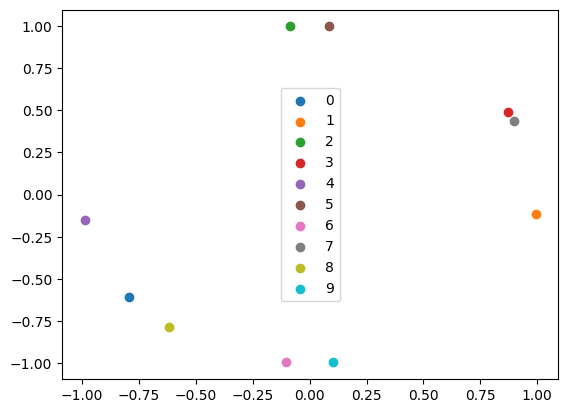

In [37]:
import matplotlib.pyplot as plt

test_embed = final_embed.mean(dim=-1)
embed_cos = torch.cos(test_embed).cpu().detach().numpy()
embed_sin = torch.sin(test_embed).cpu().detach().numpy()
for i in range(10):
  plt.scatter(embed_cos[i],embed_sin[i], label=i)
  plt.legend()
plt.show()

In [38]:
embed_norm = final_embed
cos = torch.cos(embed_norm).mean(dim=0)
sin = torch.sin(embed_norm).mean(dim=0)
R = (cos**2+sin**2)**0.5
R

tensor([0.2877, 0.2587, 0.3270, 0.3089, 0.2649, 0.2893, 0.3337, 0.3043, 0.3351,
        0.3247, 0.2975, 0.3205, 0.3323, 0.2688, 0.3312, 0.3069, 0.3025, 0.3277,
        0.3531, 0.2983, 0.3454, 0.2827, 0.3089, 0.3405, 0.3466, 0.3330, 0.3646,
        0.3098, 0.3769, 0.2884, 0.2725, 0.3451, 0.3092, 0.3120, 0.3044, 0.3221,
        0.3225, 0.3043, 0.2780, 0.2713, 0.3287, 0.2879, 0.2784, 0.2820, 0.3047,
        0.3060], device='cuda:0', dtype=torch.float64, grad_fn=<PowBackward0>)

Euclid distance between 0 and 1 is 126061.07575114907
Euclid distance between 0 and 2 is 143600.8189980601
Euclid distance between 0 and 3 is 159856.12761633075
Euclid distance between 0 and 4 is 100969.43986465635
Euclid distance between 0 and 5 is 182302.2339438763
Euclid distance between 0 and 6 is 134741.62799404914
Euclid distance between 0 and 7 is 129327.0082271229
Euclid distance between 0 and 8 is 123385.19305694294
Euclid distance between 0 and 9 is 115757.77187038976
Euclid distance between 1 and 2 is 137577.96430565213
Euclid distance between 1 and 3 is 162220.05477714105
Euclid distance between 1 and 4 is 82057.81701245304
Euclid distance between 1 and 5 is 145746.99131825852
Euclid distance between 1 and 6 is 117474.06359799398
Euclid distance between 1 and 7 is 123426.77439527029
Euclid distance between 1 and 8 is 119306.23706256383
Euclid distance between 1 and 9 is 115773.21529225307
Euclid distance between 2 and 3 is 192913.36675175547
Euclid distance between 2 and 4 

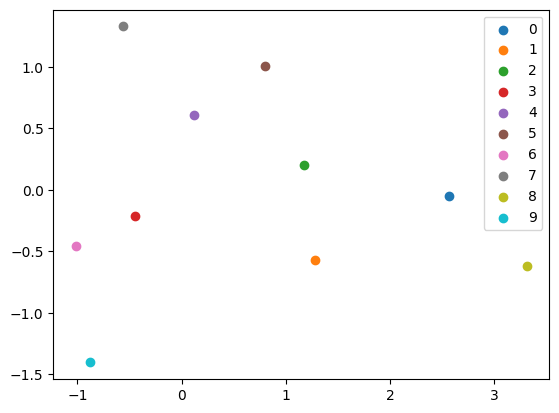

In [39]:
import matplotlib.pyplot as plt
for i in range(10):
  for j in range(i+1,10):
    distance = final_embed[i,:] - final_embed[j,:]
    distance = distance**2
    distance = distance.sum(dim=-1)
    distance = torch.sqrt(distance)
    print(f"Euclid distance between {i} and {j} is {distance}") 
  plt.scatter(model.embed.cpu().weight[i,0].detach().numpy(), model.embed.cpu().weight[i,1].detach().numpy(), label=i)
  plt.legend()

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(projection='3d')
plot_data = final_embed.cpu().detach().numpy()
ax.scatter(plot_data[:-1,0], plot_data[:-1,1], plot_data[:-1,2], c=[0,1,2,3,4,5,6,7,8,9])
plt.show()

In [ ]:
model.embed.weight[:,0].detach().numpy()

In [ ]:
final_loss = loss_func(best_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in best_bitstring])

# Process bitstring reported by GNN
size_mis, ind_set, number_violations = postprocess_gnn_mis(best_bitstring, nx_graph)
# gnn_tot_time = time() - gnn_start

print(f'Independence number found by GNN is {size_mis} with {number_violations} violations')
# print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')


In [ ]:
# Visualize result
# Note no light-blue nodes are connected by an edge
pos = nx.kamada_kawai_layout(nx_graph)
# nx.draw_networkx(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])
import matplotlib.pyplot as plt                            # 追加
fig = plt.figure()                                         # 追加 
ax = fig.add_axes([0, 0, 1, 1])                            # 追加

color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, ax=ax, with_labels=True, node_color=color_map)
